In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from fastai2.vision.all import *
from fastai2.metrics import *
from nbdev.showdoc import show_doc

### Setup

In [3]:
torch.__version__

'1.5.0'

In [4]:
path_data = Path('/Users/rahulsomani/Desktop/shot-lighting-cast')

In [9]:
dls = ImageDataLoaders.from_folder(path_data/'train', valid_pct=0.05, seed=42,
                                   item_tfms = Resize(size=224, method=ResizeMethod.Squish))

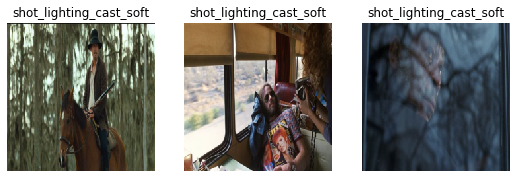

In [10]:
dls.show_batch(max_n=3)

In [11]:
class ApplyPILFilter(RandTransform):pass

learn = load_learner(path_data/'fastai2-110-epoch-model.pkl');

In [12]:
learn.dls = dls
interp = ClassificationInterpretation.from_learner(learn)

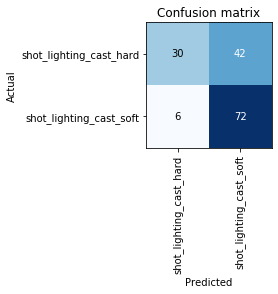

In [13]:
interp.plot_confusion_matrix()

In [26]:
class ClassificationInterpretationMod(ClassificationInterpretation):
    'Extended...'
    def _prep_label_confidence(self):
        self._preds_collated = [
            (item, self.vocab[label_idx], *preds.numpy()*100)\
            for item,label_idx,preds in zip(self.dl.items,
                                            self.targs,
                                            self.preds)
        ]

        self.preds_df       = pd.DataFrame(self._preds_collated, columns = ['fname','truth', *self.vocab])
        self._preds_df_each = {l:self.preds_df.copy()[self.preds_df.truth == l].reset_index(drop=True) for l in self.vocab}
        self.preds_df_each  = defaultdict(dict)


        sort_desc = lambda x,col: x.sort_values(col, ascending=False).reset_index(drop=True)
        for label,df in self._preds_df_each.items():
            filt = df[label] == df[self.vocab].max(axis=1)
            self.preds_df_each[label]['accurate']   = df.copy()[filt]
            self.preds_df_each[label]['inaccurate'] = df.copy()[~filt]
            
            self.preds_df_each[label]['accurate']   = sort_desc(self.preds_df_each[label]['accurate'], label)
            self.preds_df_each[label]['inaccurate'] = sort_desc(self.preds_df_each[label]['inaccurate'], label)
            assert len(self.preds_df_each[label]['accurate']) + len(self.preds_df_each[label]['inaccurate']) == len(df)
            
    def plot_label_confidence(self, bins=10, fig_width=12, fig_height_base=4, return_fig=False,
                              title='Accurate vs. Inaccurate Predictions Confidence (%) Levels Per Label'):
        'plt'
        self._prep_label_confidence()
        fig, axes = plt.subplots(nrows = len(self.preds_df_each.keys()), ncols=2,
                                 figsize = (fig_width, fig_height_base * len(self.vocab)))
        for i, (label, df) in enumerate(self.preds_df_each.items()):
            for mode,ax in zip(['inaccurate', 'accurate'], axes[i]):
                range_ = (50,100) if mode == 'accurate' else (0,50)
                ax.hist(df[mode][label], bins=bins, range=range_, rwidth=.95)
                ax.set_xlabel(f'{label}: {mode.capitalize()}')
                ax.set_ylabel(f'No. {mode.capitalize()} = {len(df[mode][label])}')
        fig.suptitle(title)
        plt.subplots_adjust(top = 0.9, bottom=0.01, hspace=0.25, wspace=0.2)
        if return_fig: return fig

In [27]:
learn.dls = dls
interp = ClassificationInterpretationMod.from_learner(learn)

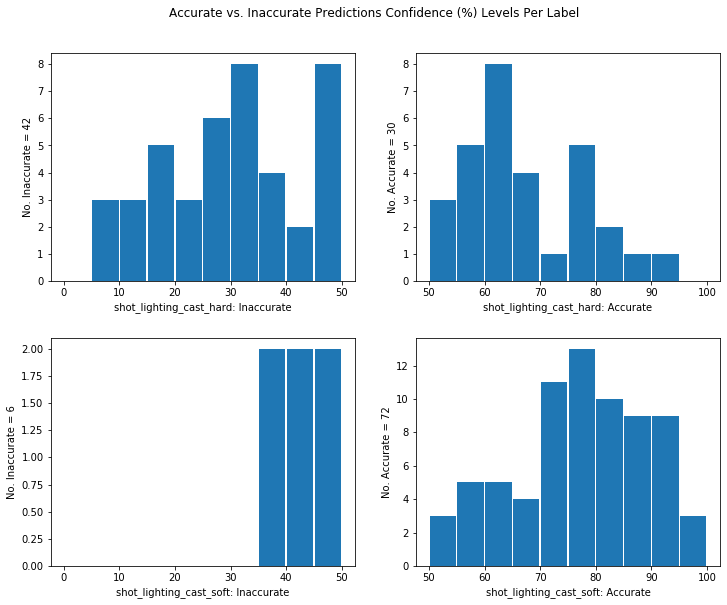

In [28]:
interp.plot_label_confidence()